# Using Voices Obscured in Complex Environmental Settings (VOiCES) data tutorial
#### M. A. Barrios   |  InQTel-Lab41  |  June 2018

This tutorial demonstrated how to load VOiCES data, sample audio files for specific types of noise, plot waveform and spectrogram. It also includes helper functions to select files given noise type, room (s), or microphone(s). Before you begin make sure you run the 'setup_audio_env.sh' to setup the same environment used here. 

In [7]:
# directory path for VOiCES  dataset
dat_dir = 'add/yourDirectory/path/VOiCES'
# directory path for VOiCES reference files
refs_dir = 'add/yourDirectory/path/VOiCES_refs/'


## Import Packages and define functions

Import packages

In [2]:
import os 
import librosa
from glob import glob
import librosa.display 
import matplotlib.pyplot as plt
import random
import IPython.display as ipd
import fnmatch
import itertools
import numpy as np
from types import *
import pandas as pd

%matplotlib inline

In [3]:
'''
For given room and noise type, randomly select and load audio file,
or load known audio file

OPTIONS:
room : (str) room id - 'rm1' or 'rm2'
noise type : (str) descriptor for noise type, corresponding to no 
            adversarial noise, babble, music, or television:
            ['none', 'babb', 'musi', 'tele'] 

OUTPUT: audio file, sr, and file path

USAGE: 
    # load randomly select file with no background recorded in room 1
    speech_file('rm1', 'none') 
    # load specific file
    speech_file ('','', 'Lab41-SRI-VOiCES-rm1-musi-sp0083-ch003054-sg0005-mc07-stu-beh-dg090.wav' )

'''
def speech_file(room, noise, filename = ''):
    if len(filename) == 0:
        # randomly choose audio file for room, noise, specs
        path = 'distant-16k/speech/'+room+'/'+noise+'/'
        sp = random.choice([f for f in os.listdir(path) if f.startswith('sp')])
        path = path+sp+'/'
        filename = random.choice(os.listdir(path))
    else:
        room = filename[17:20] 
        noise = filename[21:25]
        path = 'distant-16k/speech/'+room+'/'+noise+'/'+filename[26:filename.find('-ch')]+'/'
    x, sr = librosa.load(path+filename)
    return x, sr, path+filename #[filename.find('sp'):filename.find('-mc')]

In [4]:
'''Given noisy speech file name, load corresponding clean/source audio
OUTPUT: audio file, sr, and file path '''
def source_file(noisy_spch):
    speaker = noisy_spch[noisy_spch.find('-sp')+1:noisy_spch.find('-ch')]
    scr_file = 'source-16k/'+speaker+'/'+'Lab41-SRI-VOiCES-src'+noisy_spch[noisy_spch.find('-sp'):noisy_spch.find('-mc')]+'.wav'
    x, sr = librosa.load(scr_file)
    return x, sr, scr_file

In [5]:
'''file_list returns file paths for selected subset of audio files with 
foreground speacker at degree deg, data recorded in specific room, 
noise type and microphone selection. 

Default values are: 90 deg, all rooms, all mics, [noise selected by user]

OPTIONS: 
deg- (int) 0 thru 180 in 10 degree intervals
room- (str) room id ['rm1', 'rm2', 'all']
noise- (str) descriptor for noise type, corresponding to no 
            adversarial noise, babble, music, or television:
            ['none', 'babb', 'musi', 'tele']
mics- (str) type of microphone to be selected ['stu', 'lav', 'all'] or list of mic ID's ['02' ,'04','06']
'''

def file_list(noise, deg = 90, room = 'all', mics =['all']):
    # ------------ check function input is valid -----------
    #noise
    assert noise in ['none', 'babb', 'musi', 'tele'], 'not a valid noise type: %r'% noise
    # deg
    assert type(deg) is int, 'deg not an int: %r' % deg
    assert 0 <= deg <= 180, 'deg is out of range: %r' % deg
    # room option
    assert room in ['rm1', 'rm2', 'all'], 'not a valid room: %r' % room
    # mic options
    valid_mics = ['0'+str(f) for f in np.arange(9)+1]+[str(f) for f in np.arange(3)+10]
    if len(mics) == 1:
        assert mics[0] in ['stu', 'lav', 'all'], 'invalid mic type: %r ' %mics[0]
    else:
        for mic in mics:
            assert mic in valid_mics, 'invalid mic Id: %r ' %mic
        
    # ----------------- define parameters ------------------
    if deg < 100:
        if deg == 0: 
            degstr ='000'
        else:
            degstr = '0'+str(deg)       
    else:
        degstr = str(deg)
    if room == 'all':
        bsdir = 'distant-16k/speech/*/'
    else: 
        bsdir = 'distant-16k/speech/'+room+'/'
    
    bsdir = bsdir+noise+'/*/'
    dirs = glob(bsdir)
           
    srchStr = 'dg'+degstr+'.wav'
    spkr = []
    if mics[0] != 'all':
        if len(mics) == 1:
            srchStr = '*'+mics[0]+'*'+srchStr
            files = []
            for drctr in dirs:
                file_srch = [drctr+f for f in fnmatch.filter(os.listdir(drctr), srchStr)]
                files = files + file_srch
                if len(file_srch) > 0:
                    spkr.append(drctr[drctr[:-1].rfind('/')+3:-1] )
        else:
            files = []
            for drctr in dirs:
                for mic in mics:
                    srchStr_m = '*mc'+mic+'*'+srchStr
                    file_srch = [drctr+f for f in fnmatch.filter(os.listdir(drctr), srchStr_m)]
                    files = files + file_srch
                    if len(file_srch) > 0:
                        spkr.append(drctr[drctr[:-1].rfind('/')+3:-1] )
    return files, set(spkr)    

In [6]:
'''
Input filename path, output transcript, assumes df built from .refs file is loaded 
'''
def get_transcript(filename, df):
    file = filename[filename.rfind('/')+1: -4]
    return df[df.fileName == file].trnscrpt.tolist()[0][1:]
   

## Exploring the Data

### Reference files

In [8]:
os.chdir(refs_dir)

Speaker gender and LibriSpeech dataset

In [9]:
spkGendr = pd.read_csv('Lab41-SRI-VOiCES-speaker-gender-dataset.tbl', sep='\s+')
spkGendr.head()

,Speaker,Gender,DataSet
0,32,F,train-clean-100
1,83,F,train-clean-100
2,93,F,train-clean-360
3,112,F,train-clean-360
4,115,F,train-clean-360


In [8]:
print('Total number of speakers: ', len(spkGendr))
print('Number of females:', spkGendr.Gender[spkGendr.Gender == 'F'].count())
print('Number of males:', spkGendr.Gender[spkGendr.Gender == 'F'].count())

Total number of speakers:  300
Number of females: 150
Number of males: 150


Orthographic transcripts

In [9]:
trascript = pd.read_csv('Lab41-SRI-VOiCES.refs', header = None, names = ['fileName', 'trnscrpt'])

In [11]:
trascript.head(20)

,fileName,trnscrpt
0,Lab41-SRI-VOiCES-rm1-babb-sp0032-ch004137-sg00...,few persons can arrive at anything like the a...
1,Lab41-SRI-VOiCES-rm1-babb-sp0032-ch004137-sg00...,few persons can arrive at anything like the a...
2,Lab41-SRI-VOiCES-rm1-babb-sp0032-ch004137-sg00...,few persons can arrive at anything like the a...
3,Lab41-SRI-VOiCES-rm1-babb-sp0032-ch004137-sg00...,few persons can arrive at anything like the a...
4,Lab41-SRI-VOiCES-rm1-babb-sp0032-ch004137-sg00...,few persons can arrive at anything like the a...
5,Lab41-SRI-VOiCES-rm1-babb-sp0032-ch004137-sg00...,few persons can arrive at anything like the a...
6,Lab41-SRI-VOiCES-rm1-babb-sp0032-ch004137-sg00...,few persons can arrive at anything like the a...
7,Lab41-SRI-VOiCES-rm1-babb-sp0032-ch004137-sg00...,few persons can arrive at anything like the a...
8,Lab41-SRI-VOiCES-rm1-babb-sp0032-ch004137-sg00...,few persons can arrive at anything like the a...
9,Lab41-SRI-VOiCES-rm1-babb-sp0032-ch004137-sg00...,few persons can arrive at anything like the a...


What if we want to look at audio files at a specific foreground speaker angle?

In [12]:
os.chdir(dat_dir)

In [47]:
degree = 90
mics_input = ['stu']
noise = 'musi'

fls, speakers = file_list(noise, deg = degree, mics = mics_input)

print('Number of audio files for %s mic(s) at %d deg: %d'%(mics_input[0], degree, len(fls)))
print('Unique speakers in subset:%d'%len(speakers))

Number of audio files for stu mic(s) at 90 deg: 1024
Unique speakers in subset:104


In [48]:
# Let's just look at firs 10 files in list
fls[:10]

['distant-16k/speech/rm1/musi/sp0083/Lab41-SRI-VOiCES-rm1-musi-sp0083-ch003054-sg0005-mc01-stu-clo-dg090.wav',
 'distant-16k/speech/rm1/musi/sp0083/Lab41-SRI-VOiCES-rm1-musi-sp0083-ch003054-sg0005-mc03-stu-mid-dg090.wav',
 'distant-16k/speech/rm1/musi/sp0083/Lab41-SRI-VOiCES-rm1-musi-sp0083-ch003054-sg0005-mc05-stu-far-dg090.wav',
 'distant-16k/speech/rm1/musi/sp0083/Lab41-SRI-VOiCES-rm1-musi-sp0083-ch003054-sg0005-mc07-stu-beh-dg090.wav',
 'distant-16k/speech/rm1/musi/sp0093/Lab41-SRI-VOiCES-rm1-musi-sp0093-ch126208-sg0004-mc01-stu-clo-dg090.wav',
 'distant-16k/speech/rm1/musi/sp0093/Lab41-SRI-VOiCES-rm1-musi-sp0093-ch126208-sg0004-mc03-stu-mid-dg090.wav',
 'distant-16k/speech/rm1/musi/sp0093/Lab41-SRI-VOiCES-rm1-musi-sp0093-ch126208-sg0004-mc05-stu-far-dg090.wav',
 'distant-16k/speech/rm1/musi/sp0093/Lab41-SRI-VOiCES-rm1-musi-sp0093-ch126208-sg0004-mc07-stu-beh-dg090.wav',
 'distant-16k/speech/rm1/musi/sp0150/Lab41-SRI-VOiCES-rm1-musi-sp0150-ch126107-sg0026-mc01-stu-clo-dg090.wav',
 

### Sample data

In [15]:
os.chdir(dat_dir)
random.seed(1024)

In [60]:
# load to specific file
x, sr, nam = speech_file('','', 'Lab41-SRI-VOiCES-rm1-musi-sp0083-ch003054-sg0005-mc07-stu-beh-dg090.wav' )

In [84]:
# Play selected file
print(nam[nam.find('Lab41-SRI-VOiCES'):])
print('Transcript:')
print(get_transcript(nam, trascript))
ipd.Audio(nam)

Lab41-SRI-VOiCES-rm1-musi-sp0083-ch003054-sg0005-mc07-stu-beh-dg090.wav
Transcript:
fruit shook off the branches of the tree it grows upon by the motion of the water as those in our gardens are by that of the wind the lobster trees appeared the richest but the crab and oysters were the tallest


In [81]:
# Randomly select an audio file for a specific room and noise type
sp_x, sp_sr, sp_nam = speech_file('rm1', 'tele') 

# Let's also load the source audio for comparison
src_x, src_sr, src_nam = source_file(sp_nam)

In [85]:
# Play the noisy speech audio file
print(sp_nam[sp_nam.find('Lab41-SRI-VOiCES'):])
print('Transcript:')
print(get_transcript(sp_nam, trascript))
ipd.Audio(sp_nam)

Lab41-SRI-VOiCES-rm1-tele-sp8266-ch258263-sg0036-mc11-lav-ceo-dg070.wav
Transcript:
and said to her grieve not but take patience till thy son be grown a man when i will go to the land of the ajamis and strike off thy father's head from between his shoulders and seat thy son on the throne in his stead so she rose and kissed his hands and blessed him


In [24]:
# Play the clean source file
print(src_nam[src_nam.find('Lab41-SRI-VOiCES'):])
ipd.Audio(src_nam)

Lab41-SRI-VOiCES-src-sp4145-ch104606-sg0027.wav


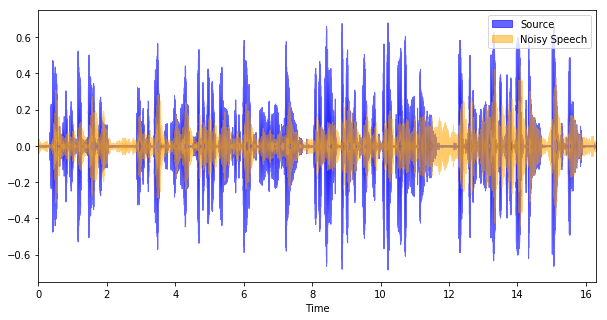

In [25]:
plt.figure(figsize = (10,5))
librosa.display.waveplot(src_x, src_sr, color = 'blue', alpha = 0.6, label = 'Source')
librosa.display.waveplot(sp_x, sr = sp_sr, alpha = 0.5, color = 'orange',label = 'Noisy Speech')
plt.legend()

Display spectrogram for clean signal and noisy speech

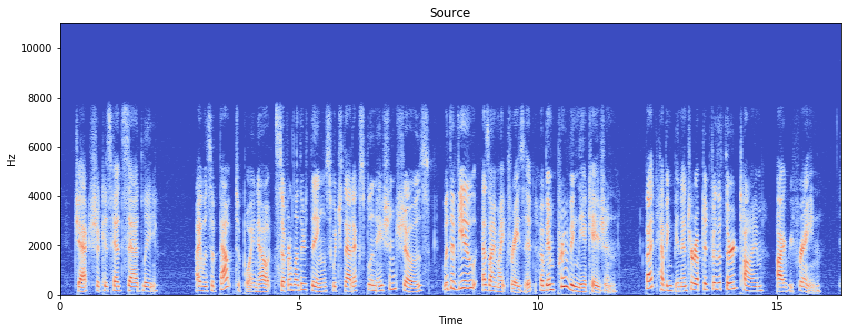

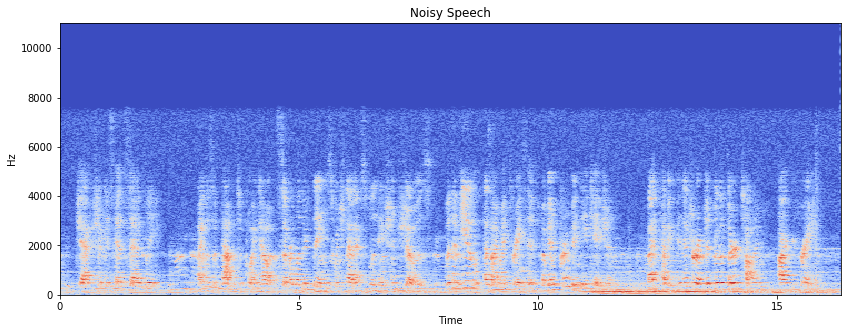

In [26]:
# source 
src_ft = librosa.stft(src_x)
src_db = librosa.amplitude_to_db(abs(src_ft))
plt.figure(figsize=(14, 5))
plt.title('Source')
librosa.display.specshow(src_db, sr=src_sr, x_axis='time', y_axis='hz')
# noisy speech
sp_ft = librosa.stft(sp_x)
sp_db = librosa.amplitude_to_db(abs(sp_ft))
plt.figure(figsize=(14, 5))
plt.title('Noisy Speech')
librosa.display.specshow(sp_db, sr=src_sr, x_axis='time', y_axis='hz')